# Advance lane finding project, Udacity 2017

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline



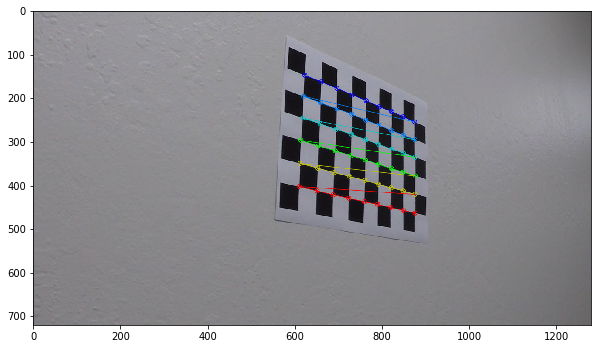

In [2]:
import glob
imagenames=glob.glob('camera_cal/calibration*.jpg')

# Calibrate the camera

objpoints=[]
imagepoints=[]
objp=np.zeros((9*6,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
# Loop through the checkboard calibration images
plt.figure(figsize=(10,10))
for imm in imagenames:
    img=mpimg.imread(imm)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)   
    # Find chessboard corners for calibration
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)  
    img2 = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    # check that the calibration image is valid
    if ret ==True:
        imagepoints.append(corners)
        objpoints.append(objp)   
        plt.imshow(img2)
# Get camera calibration    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)   



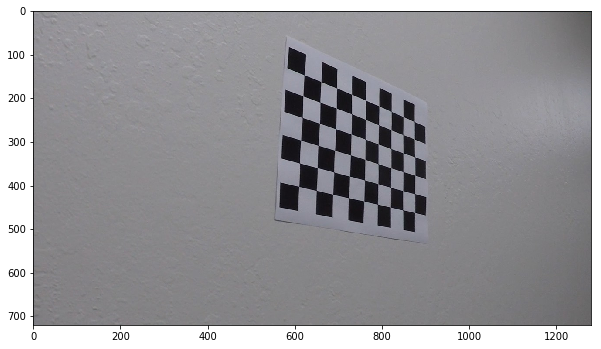

In [3]:
img=mpimg.imread(imm)
undistordet_chess = cv2.undistort(img, mtx, dist, None, mtx)  
plt.figure(figsize=(10,10))
plt.imshow(img)


In [4]:
def warp_transform(img):
    img_size=(img.shape[1],img.shape[0])
    print(img_size)

    #Perspective transform from road image to birds eye view
    
    # source points
    src=np.float32(  
         [[0,700],[1280,700],[520,470],[760,470]]    
         #another option [[160,630],[1120,630],[520,470],[760,470]]
    )
  
    offset = 0 # offset for dst points
     
    #destination points
    dst = np.float32([[offset, img_size[1]-offset],[img_size[0]-offset, img_size[1]-offset], 
                                 [offset, offset], [img_size[0]-offset, offset] ])

    # Perspective transform  
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse transform back
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv


(1280, 720)


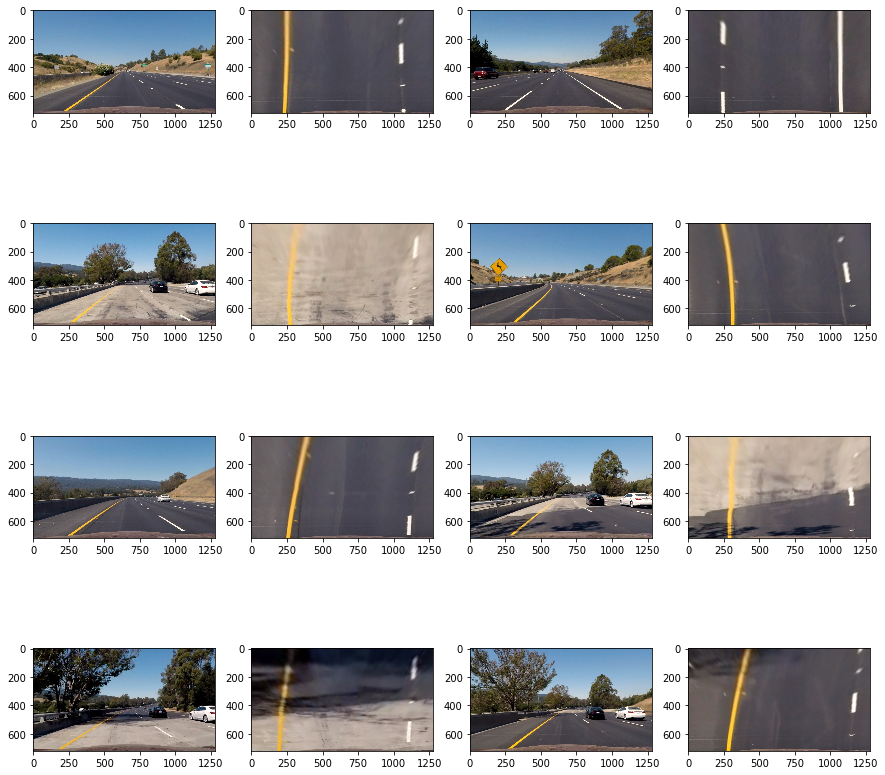

In [5]:
# Test perspective transform for the test images

imagenames=glob.glob('test_images/*.jpg')
#print(imagenames)
#%matplotlib inline

counter=0
plt.figure(figsize=(15,15))
# Perspective transform
M,Minv=warp_transform(mpimg.imread(imagenames[0]))
img_size=(img.shape[1],img.shape[0])
for imm in imagenames:
    counter=counter+1
    img=mpimg.imread(imm)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Undistort images by camera calibration matrix
    dst = cv2.undistort(img, mtx, dist, None, mtx)  
    
    plt.subplot(4,4,counter) 
    plt.imshow(dst)
    # Perspective transform
    warpedd= cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    counter=counter+1
    plt.subplot(4,4,counter) 
    plt.imshow(warpedd)
    



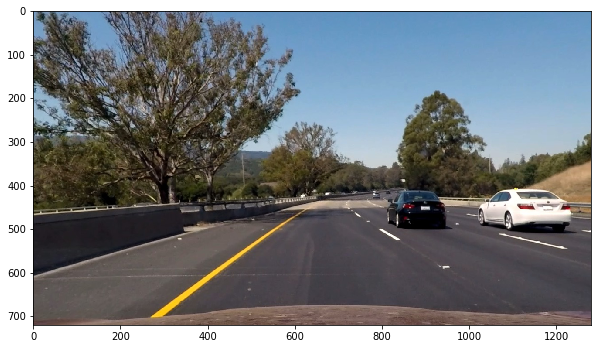

In [6]:

#undistordet_chess = cv2.undistort(img, mtx, dist, None, mtx)  
plt.figure(figsize=(10,10))
plt.imshow(dst)

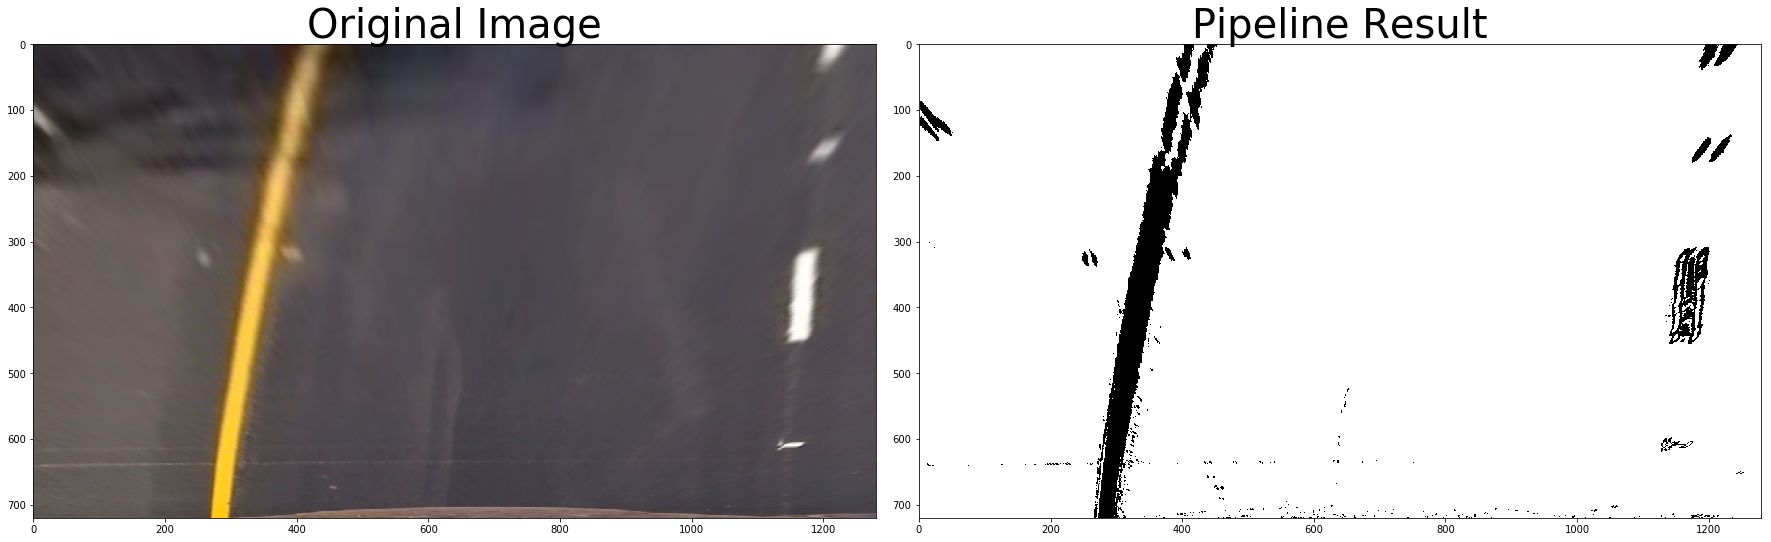

In [7]:

# Binarization pipeline
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.maximum(sxbinary,s_binary)
    
    return color_binary

# Create one test image
image=warpedd
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='Greys')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

C:\Users\v-ilhuop\AppData\Local\Continuum\Miniconda2\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

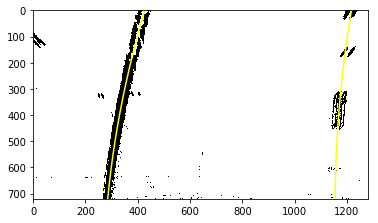

In [8]:
# Calculation of curvatures by Sliding window 
def calculate_curvatures(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image

    # Create an output image to draw on and  visualize the result

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

def calculate_fit(left_fit,right_fit,binary_warped):
    #print(left_fit)
    #print(right_fit)
    #Visualization
    #At this point, you're done! But here is how you can visualize the result as well:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty,left_fitx,right_fitx

#example
bin_warp=result
left_fit,right_fit=calculate_curvatures(bin_warp)
ploty,left_fitx,right_fitx=calculate_fit(left_fit,right_fit,bin_warp)

out_img=result
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img,cmap='Greys')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

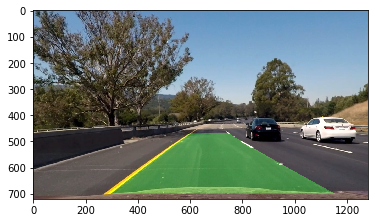

In [9]:
# Warp back from birds eye view to front view
# Green lane markings are drawn in the birds eye view and brought back to front view
def warp_back(warped,undist,ploty,left_fitx,right_fitx):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


resultt=warp_back(bin_warp,dst,ploty,left_fitx,right_fitx)
plt.imshow(resultt)

In [10]:
def calculate_realcurvature(ploty,leftx,rightx):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
   
    # Example values: 632.1 m    626.2 m
    deviation=(rightx[2]+leftx[2]-1280)*xm_per_pix/(-2)
    return left_curverad,right_curverad,deviation

In [11]:
# Define a class to receive the characteristics of each line detection
# Only some of the fields are in use
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.counter=0
        self.fit_averaged=0
        self.error_frame_count=0
        
left_line=Line()
right_line=Line()


In [12]:
# The full image frame processing pipeline
def pipel(image):
    # Undistort image
    undistorted=cv2.undistort(image, mtx, dist, None, mtx)
    # Warp image   
    warpedd= cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    # Binarize the warped image
    binary_warped=pipeline(warpedd, s_thresh=(170, 255), sx_thresh=(20, 100))
    # Calculate curvature
    left_fit,right_fit=calculate_curvatures(binary_warped)
    
    # By defaul good detection is true
    good_lane_detected=True

    left_line.counter+=1
    # Keep a counter that in the beginning of the video, a few frames are kept anyway
    if(left_line.counter>3): 
        # If a new frame has considerably different curvature than the current smoothed lane
        # consider it an undetected lane image
        if(left_fit[0]/left_line.fit_averaged[0]>20):
            good_lane_detected=False
        if(right_fit[0]/right_line.fit_averaged[0]>20):
            good_lane_detected=False
        if(left_line.fit_averaged[0]/left_fit[0]>20):
            good_lane_detected=False
        if(right_line.fit_averaged[0]/right_fit[0]>20):
            good_lane_detected=False
            
    # If 5 erroneous frames have been found, time to reset        
    if(left_line.error_frame_count<3):
          good_lane_detected=True
    
    # If good lane lines have been detected, add fitted lines to a running list of 20 recent good lanes
    if(good_lane_detected==True):
        left_line.error_frame_count=0
        left_line.recent_xfitted.append(left_fit)
        if(len(left_line.recent_xfitted)>10):
            left_line.recent_xfitted=left_line.recent_xfitted[1:]
        right_line.recent_xfitted.append(right_fit)
        if(len(right_line.recent_xfitted)>10):
            right_line.recent_xfitted=right_line.recent_xfitted[1:]
    else:
        # Otherwise extend the count of currently found bad, undetected lanes
        left_line.error_frame_count+=1

    # Calculate smoothed averages
    left_fit_averaged=np.mean(np.vstack(left_line.recent_xfitted),axis=0)
    right_fit_averaged=np.mean(np.vstack(right_line.recent_xfitted),axis=0)
    # Save to the object
    left_line.fit_averaged=left_fit_averaged
    right_line.fit_averaged=right_fit_averaged
    # Fit the lane parameters to pixel values
    ploty,left_fitx,right_fitx=calculate_fit(left_fit_averaged,right_fit_averaged,binary_warped)
    #Calculate curvature and car position in meters   
    left_realcurv,right_realcurv,deviation=calculate_realcurvature(ploty,left_fitx,right_fitx)
    # Warp the image with lanes detected and drawn from bird's eye view to front view  
    warped_back=warp_back(binary_warped,undistorted,ploty,left_fitx,right_fitx)

    font = cv2.FONT_HERSHEY_SIMPLEX
    # Mean of left and right curvature
    mean_curv=np.int32(np.floor(   (abs(left_realcurv)+abs(right_realcurv))/(2)))
    # Plot text
    cv2.putText(warped_back,'Radius of curvature  = %.2f m'%(mean_curv),(60,60), font, 1,(255,255,255),2,cv2.LINE_AA)    
    cv2.putText(warped_back,'Vehicle is from the center : %.2f m %s '%(abs(deviation), 'left' if deviation < 0 else 'right'),(60,120),font, 1,(255,255,255),2,cv2.LINE_AA)
                
    return warped_back

C:\Users\v-ilhuop\AppData\Local\Continuum\Miniconda2\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


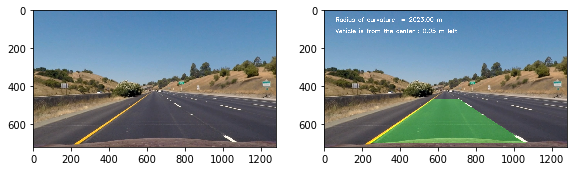

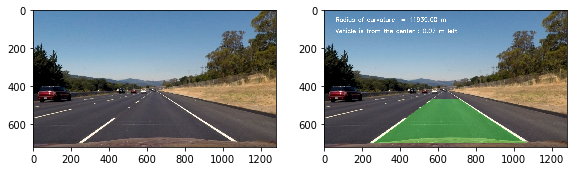

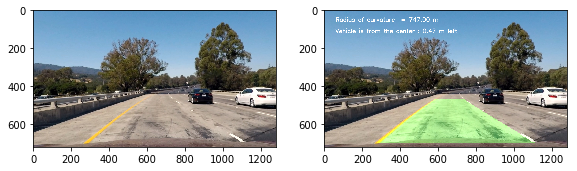

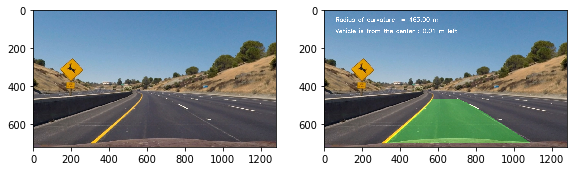

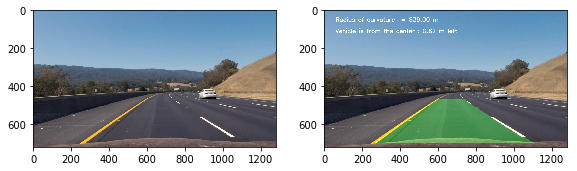

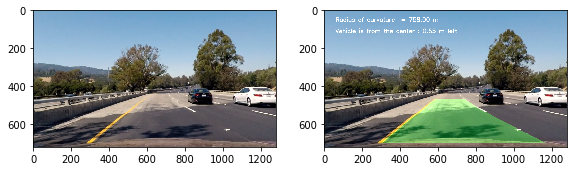

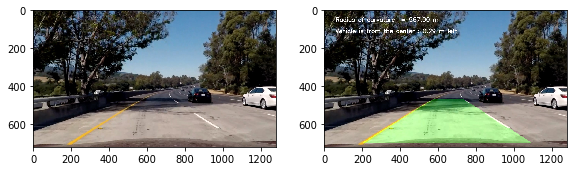

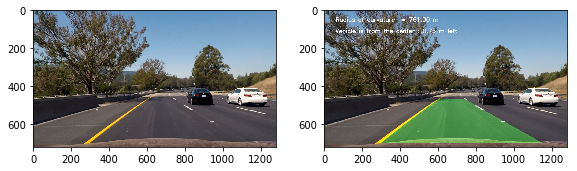

In [13]:
# Lane detection for the test images
imagenames=glob.glob('test_images/*.jpg')
#print(imagenames)
#%matplotlib inline

counter=0

for imm in imagenames:
    counter=counter+1
    img=mpimg.imread(imm)
    left_line=Line()
    right_line=Line()
    piped=pipel(img)
   
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(figsize=(20,20))
    
    plt.subplot(4,4,counter) 
    plt.imshow(dst)
    
    warpedd= cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    counter=counter+1
    plt.subplot(4,4,counter) 
    plt.imshow(piped)
   

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Run frame by frame to the project video
left_line=Line()
right_line=Line()
project_output1 = 'project_output.mp4'
clip2 = VideoFileClip('project_video.mp4')

yellow_clip = clip2.fl_image(pipel)
%time yellow_clip.write_videofile(project_output1, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output1))

In [ ]:
# Run frame by frame to the challenge video, did not work too well, not shown
left_line=Line()
right_line=Line()
challenge_output = 'challenge_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(pipel)
%time yellow_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
# Run frame by frame to the hard challenge video, did not work too well, not shown
left_line=Line()
right_line=Line()
harder_challenge_output = 'harder_challenge_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
yellow_clip = clip2.fl_image(pipel)
%time yellow_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))